### Step 0: Import Image
Import Images for Background and Object.

In [191]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_image(title, img):
    plt.figure(figsize=(10, 6))
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

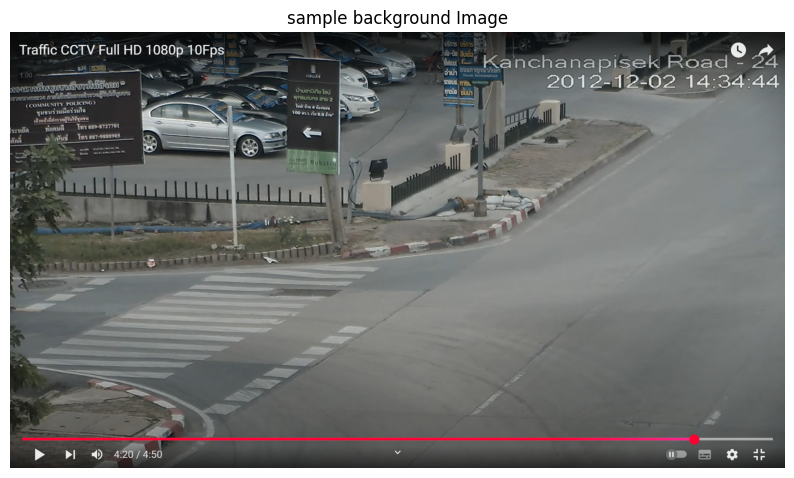

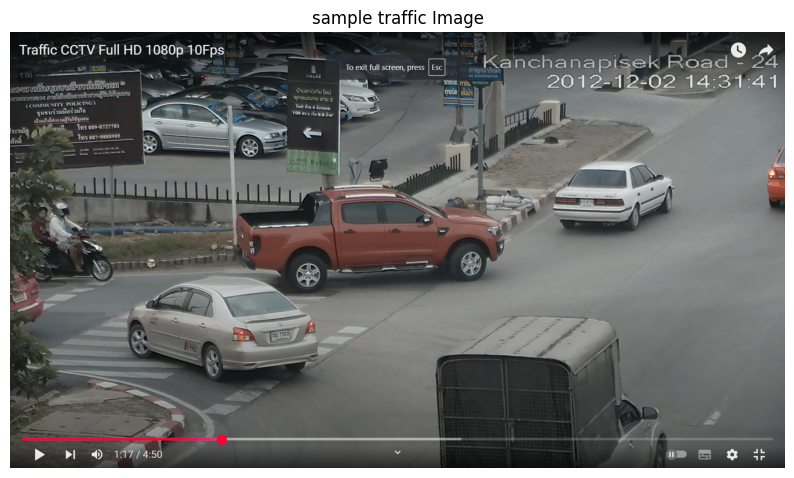

In [192]:
# Load the image (replace with your image path)
background = cv2.imread("background.png")
image = cv2.imread("img2.png")


if background is None or image is None:
    raise ValueError("One or both images not found.")

show_image("sample background Image", background)
show_image("sample traffic Image", image)


### Step 1: Masking Unnecessary Parts
Mask out non-road areas such as sidewalks or opposite lanes.

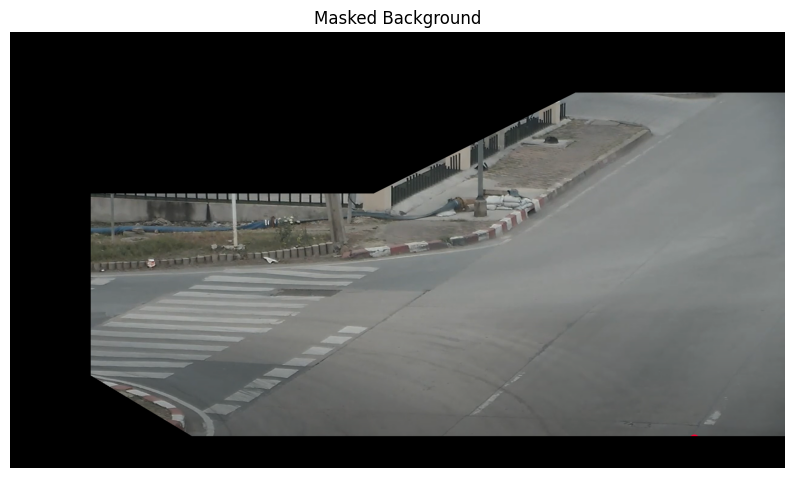

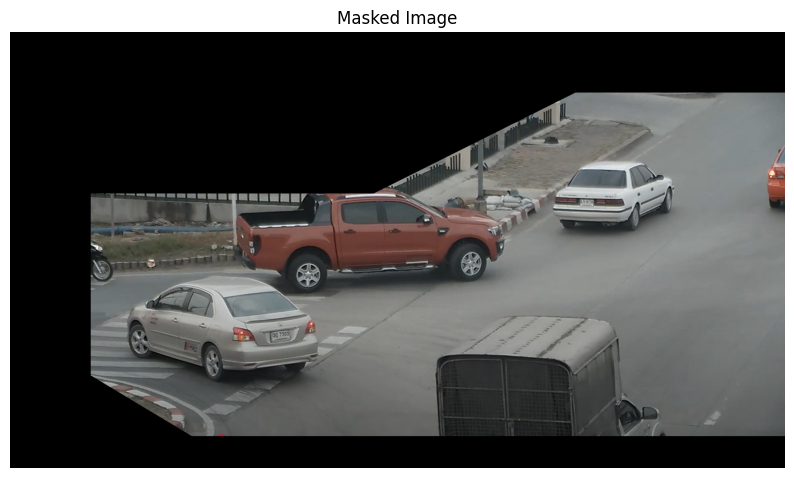

In [193]:
# Define the region to keep (road area)
#region = np.array([[400, 500], [550, 500], [1200, 1100], [1200, 1200], [0, 1200], [0, 750]], dtype=np.int32)
region = np.array([[200, 400], [900, 400], [1400, 150], [2000, 150], [2000, 1000], [450, 1000], [200, 850]], dtype=np.int32)

# Create a black mask
mask = np.zeros(background.shape[:2], dtype=np.uint8)

# Fill the road region with white
cv2.fillPoly(mask, [region], 255)

# Apply the mask to keep only the road
masked_background = cv2.bitwise_and(background, background, mask=mask)
masked_image = cv2.bitwise_and(image, image, mask=mask)

# Save the result
show_image("Masked Background", masked_background)
show_image("Masked Image", masked_image)

### Step 2: Convert to Grayscale
Convert the masked image to grayscale for further processing.

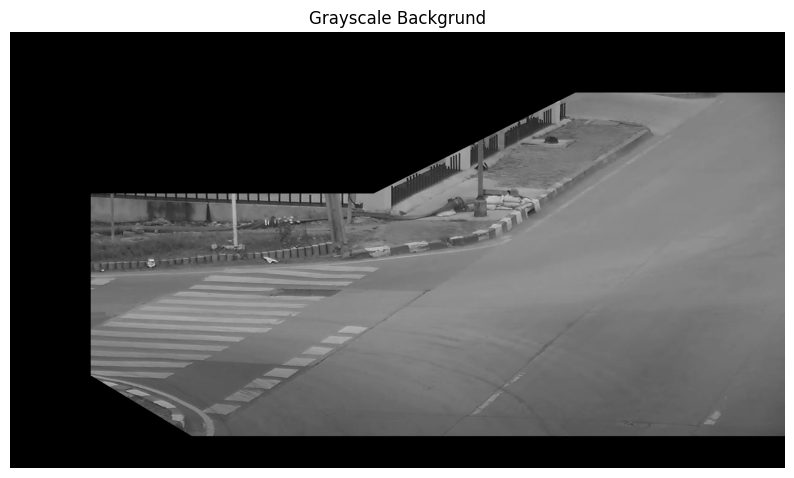

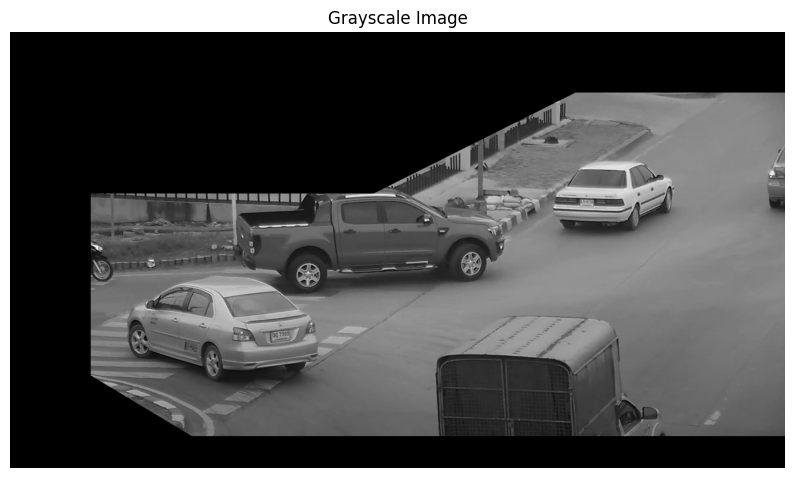

In [194]:

gray_background = cv2.cvtColor(masked_background, cv2.COLOR_BGR2GRAY)
gray_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

show_image("Grayscale Backgrund", gray_background)
show_image("Grayscale Image", gray_image)


### Step 3: Background Subtraction
Apply background subtraction to detect moving objects (e.g., cars).

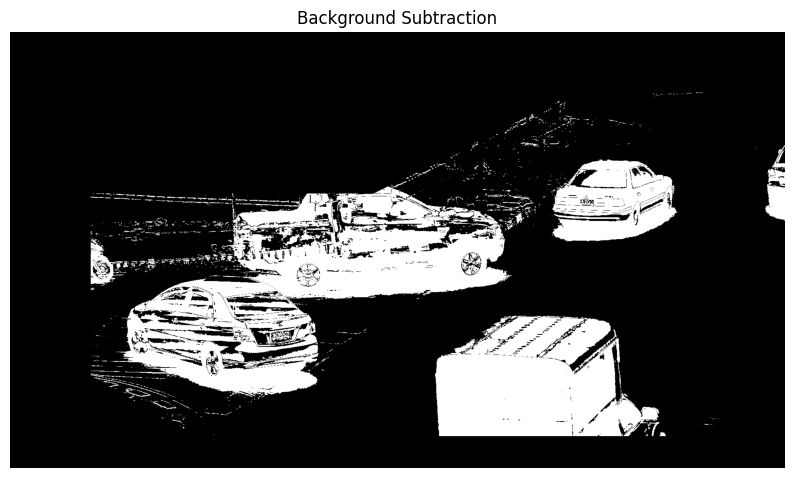

In [195]:
fgbg = cv2.createBackgroundSubtractorMOG2(detectShadows=False)
fgbg.apply(gray_background)  # ให้โมเดลเรียนรู้ฉากหลัง
fgmask = fgbg.apply(gray_image)
show_image("Background Subtraction", fgmask)

### Step 4: Erosion and Dilation
Remove noise and connect fragmented object parts using morphological operations.

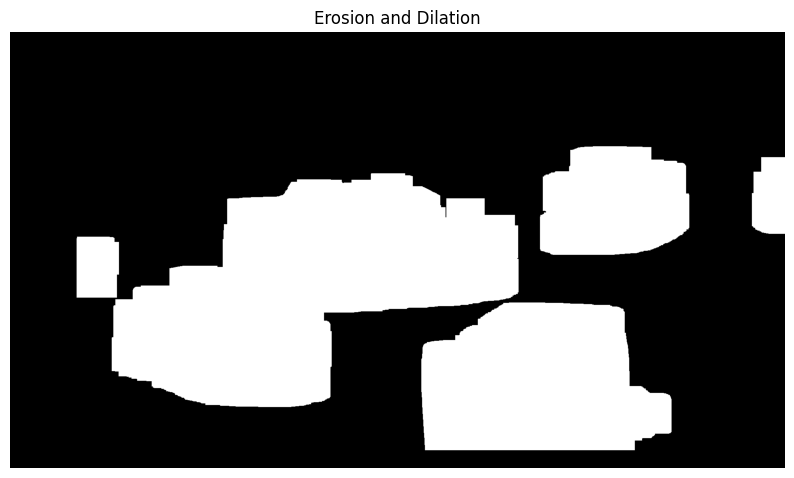

In [196]:
kernel = np.ones((3, 3), np.uint8)
eroded = cv2.erode(fgmask, kernel, iterations=5)
dilated = cv2.dilate(eroded, kernel, iterations=40)
show_image("Erosion and Dilation", dilated)

### Step 5: Contour Detection
Detect object edges using contours.

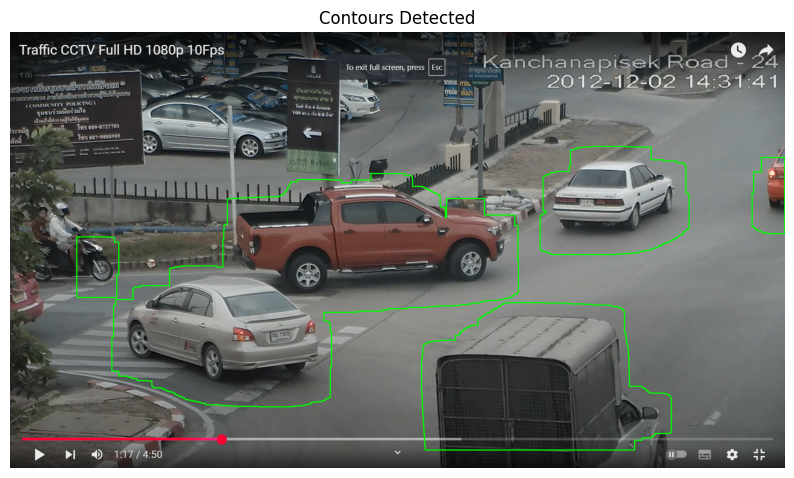

In [197]:
contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contour_image = image.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)
show_image("Contours Detected", contour_image)

### Step 6: Car Estimation by Zone
Estimate number of cars by dividing the image into zones (y-axis) and evaluating contour sizes.

In [198]:
vehicle_area = 0
vehicle_count = 0

for c in contours:
    area = cv2.contourArea(c)
    x, y, w, h = cv2.boundingRect(c)
    aspect_ratio = w / h if h != 0 else 0
    
    vehicle_area += area
    vehicle_count += 1

print(f"Estimated Vehicle Count: {vehicle_count}")
print(f"Vehicle Area: {vehicle_area:.2f} pixels")

Estimated Vehicle Count: 5
Vehicle Area: 646914.50 pixels


### Step 7: Traffic Congestion Classification
Classify traffic condition based on the ratio of vehicle area to total image area.

In [199]:
total_area = np.count_nonzero(mask)
congestion_ratio = vehicle_area / total_area

if congestion_ratio > 0.7:
    status = "Jammed"
elif congestion_ratio >= 0.4:
    status = "Heavy"
else:
    status = "Flow"

print(f"Vehicle Area: {vehicle_area}")
print(f"Total Area: {total_area}")
print(f"Congestion Ratio: {congestion_ratio:.4f}")
print(f"Traffic Status: {status}")

Vehicle Area: 646914.5
Total Area: 1207145
Congestion Ratio: 0.5359
Traffic Status: Heavy


### Step 8: Export Data
Save traffic estimation result to output image.

In [200]:
import csv
import cv2
import numpy as np

# คำนวณขนาดของพื้นที่ด้านบนสำหรับ Label
image_height, image_width = contour_image.shape[:2]
label_height = 100  # กำหนดความสูงของพื้นที่สำหรับ Label

# สร้างภาพใหม่ที่มีพื้นที่ด้านบนเพิ่มขึ้น
new_height = image_height + label_height
expanded_image = np.zeros((new_height, image_width, 3), dtype=np.uint8)  # พื้นหลังสีดำ
expanded_image[label_height:, :] = contour_image  # วางรูปเดิมลงไปด้านล่าง

# กำหนดข้อความ Label
text = f"Traffic: {status} ({congestion_ratio:.4f})"
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 2
thickness = 3

# คำนวณขนาดของข้อความ
(text_width, text_height), _ = cv2.getTextSize(text, font, font_scale, thickness)

# ตำแหน่งให้ข้อความอยู่ตรงกลางด้านบน
text_x = (image_width - text_width) // 2
text_y = (label_height + text_height) // 2

# วาดข้อความลงในพื้นที่ด้านบน
cv2.putText(expanded_image, text, (text_x, text_y), font, font_scale, (255, 255, 255), thickness)

# บันทึกภาพ Contour เป็นไฟล์
output_image_path = "output_image.png"
cv2.imwrite(output_image_path, expanded_image)

# แสดงผลข้อมูล
print(f"Contour image saved as {output_image_path}")
print(f"Congestion Ratio: {congestion_ratio:.4f}")
print(f"Traffic Status: {status}")


Contour image saved as output_image.png
Congestion Ratio: 0.5359
Traffic Status: Heavy


### Step 9: Multiple Images

In [201]:
import cv2
import numpy as np
import os

input_dir = "image_input"
output_dir = "image_output"
background_filename = "background.png"

# Step 1: Define ROI (Region of Interest)
region = np.array([[200, 400], [900, 400], [1400, 150], [2000, 150], [2000, 1000], [450, 1000], [200, 850]], dtype=np.int32)


# สร้าง output directory
os.makedirs(output_dir, exist_ok=True)

# ===== โหลดและเตรียม background  =====
background_path = os.path.join(input_dir, background_filename)
background = cv2.imread(background_path)
if background is None:
    raise ValueError(f"{background_filename} not found in {input_dir}/")

# สร้าง mask หนึ่งครั้ง
mask = np.zeros(background.shape[:2], dtype=np.uint8)
cv2.fillPoly(mask, [region], 255)

# Step 2: Apply mask และแปลง background เป็น grayscale
background_masked = cv2.bitwise_and(background, background, mask=mask)
gray_background = cv2.cvtColor(background_masked, cv2.COLOR_BGR2GRAY)

# ===== LOOP: ประมวลผล image ทีละรูป =====
for filename in os.listdir(input_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')) and filename != background_filename:
        image_path = os.path.join(input_dir, filename)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Warning: Failed to load {filename}")
            continue

        # Step 2: Apply mask และแปลง image เป็น grayscale
        masked_image = cv2.bitwise_and(image, image, mask=mask)
        gray_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

        # Step 3: Background Subtraction =====
        fgbg = cv2.createBackgroundSubtractorMOG2(detectShadows=False)
        fgbg.apply(gray_background)  # ให้โมเดลเรียนรู้ฉากหลัง
        fgmask = fgbg.apply(gray_image)
        #show_image("Background Subtraction", fgmask)

        # Step 4: Erosion + Dilation =====
        kernel = np.ones((3, 3), np.uint8)
        eroded = cv2.erode(fgmask, kernel, iterations=5)
        dilated = cv2.dilate(eroded, kernel, iterations=40)
        #show_image("Erosion and Dilation", dilated)
        
        # Step 5: Find Contours 
        contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour_image = image.copy()
        cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

        # Step 6: Car Estimation by Zone
        vehicle_area = 0
        vehicle_count = 0

        for c in contours:
            area = cv2.contourArea(c)
            x, y, w, h = cv2.boundingRect(c)
            aspect_ratio = w / h if h != 0 else 0
            
            vehicle_area += area
            vehicle_count += 1

        # Step 7: Traffic Congestion Classification
        total_area = np.count_nonzero(mask)
        congestion_ratio = vehicle_area / total_area

        if congestion_ratio > 0.7:
            status = "Jammed"
        elif congestion_ratio >= 0.4:
            status = "Heavy"
        else:
            status = "Flow"

        # Step 8: Save Output =====
        # คำนวณขนาดของพื้นที่ด้านบนสำหรับ Label
        image_height, image_width = contour_image.shape[:2]
        label_height = 100  # กำหนดความสูงของพื้นที่สำหรับ Label

        # สร้างภาพใหม่ที่มีพื้นที่ด้านบนเพิ่มขึ้น
        new_height = image_height + label_height
        expanded_image = np.zeros((new_height, image_width, 3), dtype=np.uint8)  # พื้นหลังสีดำ
        expanded_image[label_height:, :] = contour_image  # วางรูปเดิมลงไปด้านล่าง

        # กำหนดข้อความ Label
        text = f"Traffic: {status} ({congestion_ratio:.4f})"
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 2
        thickness = 3

        # คำนวณขนาดของข้อความ
        (text_width, text_height), _ = cv2.getTextSize(text, font, font_scale, thickness)

        # ตำแหน่งให้ข้อความอยู่ตรงกลางด้านบน
        text_x = (image_width - text_width) // 2
        text_y = (label_height + text_height) // 2

        # วาดข้อความลงในพื้นที่ด้านบน
        cv2.putText(expanded_image, text, (text_x, text_y), font, font_scale, (255, 255, 255), thickness)

        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, expanded_image)
        print(f"Processed: {filename} -> {output_path}")




Processed: img1.png -> image_output\img1.png
Processed: img10.png -> image_output\img10.png
Processed: img11.png -> image_output\img11.png
Processed: img12.png -> image_output\img12.png
Processed: img13.png -> image_output\img13.png
Processed: img14.png -> image_output\img14.png
Processed: img15.png -> image_output\img15.png
Processed: img16.png -> image_output\img16.png
Processed: img2.png -> image_output\img2.png
Processed: img3.png -> image_output\img3.png
Processed: img4.png -> image_output\img4.png
Processed: img5.png -> image_output\img5.png
Processed: img6.png -> image_output\img6.png
Processed: img7.png -> image_output\img7.png
Processed: img8.png -> image_output\img8.png
Processed: img9.png -> image_output\img9.png


### Step 10: Apply with Video

In [202]:
import cv2
import numpy as np
import os

# ====== CONFIG ======
video_input_path = "video_input.mp4"
background_image_path = "background.png"
output_video_path = "video_output.mp4"
process_interval_sec = 1

# ROI (Region of Interest)
region = np.array([[200, 400], [900, 400], [1400, 150], [2000, 150], [2000, 1000], [450, 1000], [200, 850]], dtype=np.int32)

# ====== LOAD BACKGROUND ======
background = cv2.imread(background_image_path)
if background is None:
    raise ValueError(f"Background image not found: {background_image_path}")

# Create mask
mask = np.zeros(background.shape[:2], dtype=np.uint8)
cv2.fillPoly(mask, [region], 255)

# Apply mask to background
background_masked = cv2.bitwise_and(background, background, mask=mask)
gray_background = cv2.cvtColor(background_masked, cv2.COLOR_BGR2GRAY)

# ====== LOAD VIDEO ======
cap = cv2.VideoCapture(video_input_path)
if not cap.isOpened():
    raise ValueError(f"Cannot open video file: {video_input_path}")

fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
output_size = (frame_width, frame_height + 100)

# ====== VIDEO WRITER ======
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, output_size)

# ====== PROCESS FRAME BY FRAME ======
frame_count = 0
interval_frames = int(fps * process_interval_sec)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count % interval_frames == 0:
        # Resize mask to match current frame
        resized_mask = cv2.resize(mask, (frame.shape[1], frame.shape[0]))

        # Step 2: Apply mask & convert to grayscale
        masked_image = cv2.bitwise_and(frame, frame, mask=resized_mask)
        gray_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)

        # Step 3: Background subtraction
        fgmask = fgbg.apply(gray_image)

        # Step 4: Erosion + Dilation
        kernel = np.ones((3, 3), np.uint8)
        eroded = cv2.erode(fgmask, kernel, iterations=5)
        dilated = cv2.dilate(eroded, kernel, iterations=40)

        # Step 5: Contour Detection
        contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contour_image = frame.copy()
        cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

        # Step 6: Car Estimation
        vehicle_area = sum(cv2.contourArea(c) for c in contours)
        total_area = np.count_nonzero(resized_mask)
        congestion_ratio = vehicle_area / total_area if total_area else 0

        if congestion_ratio > 0.7:
            status = "Jammed"
        elif congestion_ratio >= 0.4:
            status = "Heavy"
        else:
            status = "Flow"

        # Step 7: Add label space
        label_height = 100
        image_height, image_width = contour_image.shape[:2]
        expanded_image = np.zeros((image_height + label_height, image_width, 3), dtype=np.uint8)
        expanded_image[label_height:, :] = contour_image

        # Step 8: Draw text label
        text = f"Traffic: {status} ({congestion_ratio:.4f})"
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 2
        thickness = 3
        (text_width, text_height), _ = cv2.getTextSize(text, font, font_scale, thickness)
        text_x = (image_width - text_width) // 2
        text_y = (label_height + text_height) // 2
        cv2.putText(expanded_image, text, (text_x, text_y), font, font_scale, (255, 255, 255), thickness)

        # Write to output video
        out.write(expanded_image)

    frame_count += 1

# ====== CLEAN UP ======
cap.release()
out.release()
cv2.destroyAllWindows()

print(f"Finished processing. Output saved to: {output_video_path}")


Finished processing. Output saved to: video_output.mp4
